<a href="https://colab.research.google.com/github/alisonmitchell/Biomedical-Knowledge-Graph/blob/main/05_Relation_Extraction/REBEL_LlamaIndex.ipynb"
   target="_parent">
   <img src="https://colab.research.google.com/assets/colab-badge.svg"
      alt="Open in Colab">
</a>

# REBEL and LlamaIndex

## 1. Introduction

LlamaIndex is a data framework which simplifies the development of applications powered by language models. It excels in search, data indexing and retrieval, focusing on applications that benefit from context augmentation, such as Retrieval Augmented Generation (RAG) systems.

LlamaIndex supports building and querying across knowledge graphs as demonstrated in the LlamaIndex [REBEL + Knowledge Graph Index tutorial](https://colab.research.google.com/drive/1G6pcR0pXvSkdMQlAK_P-IrYgo-_staxd?usp=sharing). It works by extracting and storing triplets in the form of `(subject, relation, object)`. Then at query time, keywords from the query text are used to fetch triplets and the text chunks they came from to answer queries.

The default settings use the LLM to build the knowledge graph which can be slow and very high in token usage. We will use [REBEL](https://github.com/Babelscape/rebel) again as it is a lighter-weight model fine-tuned for triplet extraction, and compare with the default using Llama3-70b, a supported [Groq](https://docs.llamaindex.ai/en/stable/examples/llm/groq/) model which can be used with LlamaIndex.



## 2. Install/import libraries

In [ ]:
!pip install transformers llama-index llama-index-llms-groq llama-index-embeddings-huggingface pyvis networkx thefuzz

In [ ]:
!pip install -q groq

In [ ]:
import torch
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
import json
import time
import math
import IPython
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
from transformers import pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from groq import Groq
from llama_index.llms.groq import Groq
from llama_index.core import KnowledgeGraphIndex, Settings, Document, StorageContext
from llama_index.core.graph_stores import SimpleGraphStore
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from pyvis.network import Network
from IPython.display import display, HTML

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
# load Groq API key
with open("api_keys.json") as f:
    data = json.load(f)

In [ ]:
groq_api_key = data['keys']["GROQ_API_KEY"]

## 3. REBEL



### 3.1 Model and Tokeniser using transformers

To have full control over all model parameters for triple extraction, we will use the `transformers` library and the `generate()` function.

In [ ]:
# Load model and tokeniser
tokenizer = AutoTokenizer.from_pretrained('Babelscape/rebel-large')
model = AutoModelForSeq2SeqLM.from_pretrained('Babelscape/rebel-large')
gen_kwargs = {
    "max_length": 256,
    "length_penalty": 0,
    "num_beams": 10,
    "num_return_sequences": 10,
}

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/344 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

### 3.2 Remove hallucinations

In [ ]:
# Adapted from https://github.com/tomasonjo/blogs/blob/master/llm/Llamaindex-rebel-neo4j.ipynb

def clean_triplets(input_text, triplets):
    """Sometimes the model hallucinates, so we filter out entities
       not present in the text"""
    text = input_text.lower()
    clean_triplets = []
    for triplet in triplets:
        head = triplet["head"].lower()
        tail = triplet["tail"].lower()

        if head == tail:
            continue

        # Use re.search to find exact word matches in the text
        head_match = re.search(r'\b' + re.escape(head) + r'\b', text)
        tail_match = re.search(r'\b' + re.escape(tail) + r'\b', text)

        if head_match and tail_match:
            clean_triplets.append((triplet["head"], triplet["type"], triplet["tail"]))

    return clean_triplets

### 3.3 Extract triples

In [ ]:
# Function to parse the generated text and extract the triplets

def extract_triplets(input_text):
    # Tokenise text
    model_inputs = tokenizer(input_text, max_length=256, padding=True, truncation=True, return_tensors='pt').to(device)

    # Generate tokens
    generated_tokens = model.generate(
        model_inputs["input_ids"],
        attention_mask=model_inputs["attention_mask"],
        **gen_kwargs,  # Apply generation settings
    )

    # Decode generated tokens
    decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)

    triplets = []
    for decoded_pred in decoded_preds:
        relation, subject, object_ = '', '', ''
        current = 'x'
        for token in decoded_pred.strip().replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
            if token == "<triplet>":
                current = 't'
                if relation:
                    triplets.append({'head': subject.strip(), 'type': relation.strip(), 'tail': object_.strip()})
                    relation, subject, object_ = '', '', ''
            elif token == "<subj>":
                current = 's'
                if relation:
                    triplets.append({'head': subject.strip(), 'type': relation.strip(), 'tail': object_.strip()})
                object_ = ''
            elif token == "<obj>":
                current = 'o'
                relation = ''
            else:
                if current == 't':
                    subject += ' ' + token
                elif current == 's':
                    object_ += ' ' + token
                elif current == 'o':
                    relation += ' ' + token

        if subject and relation and object_:
            triplets.append({'head': subject.strip(), 'type': relation.strip(), 'tail': object_.strip()})

    # Clean and deduplicate triplets
    clean = clean_triplets(input_text, triplets)
    unique_triples = list(set(clean))
    return unique_triples

## 4. LlamaIndex

### 4.1 Configure Settings

The [`Settings`](https://docs.llamaindex.ai/en/stable/module_guides/supporting_modules/settings/) object is a bundle of commonly used resources used during the indexing and querying stage in a LlamaIndex workflow/application. It can be used to set the global configuration.

Local configurations (transformations, LLMs, embedding models) can be passed directly into the interfaces that make use of them.

We will configure the following attributes on the `Settings` object:

* LLM - we will use Llama3-70b, one of the supported Groq models, to respond to  prompts and queries, and for writing natural language responses.

* Embed model - we will use the [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) pretrained Sentence Transformers model to convert text to numerical representations, used for calculating similarity and top-k retrieval.

* Chunk Size - chunk size is the maximum number of tokens that a chunk can contain and determining the optimal chunk size is about striking a balance: capturing all essential information without sacrificing speed. We will choose a `chunk_size` of 512 tokens, which is half the default 1024. A smaller chunk size means the embeddings are more precise, while a larger chunk size means that the embeddings may be more general, but can miss fine-grained details.

* Chunk Overlap - we will leave the default `chunk_overlap` of 20 tokens, meaning that the text will be split into chunks of 512 tokens each, with an overlap of 20 tokens between each chunk.



In [ ]:
Settings.llm = Groq(model="llama3-70b-8192", api_key=groq_api_key)
Settings.embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2")
Settings.chunk_size = 512
Settings.chunk_overlap = 20

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### 4.2 Load data

We will extract triples from 10 articles for 1224 sentences containing at least one entity identified by KAZU during the NER and Linking step.

In [ ]:
# load data for 1224 sentences with at least one entity
with open('2024-06-10_text_ner_labels_1224.pickle', "rb") as f:
    text_df = pickle.load(f)

In [ ]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224 entries, 0 to 1223
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            1224 non-null   object
 1   text_ner        1224 non-null   object
 2   text_ner_label  1224 non-null   object
 3   idx             1224 non-null   object
 4   article_id      1224 non-null   object
dtypes: object(5)
memory usage: 47.9+ KB


In [ ]:
text_df.head()

,text,text_ner,text_ner_label,idx,article_id
0,"Since the 1990s, the repositioning of sildenaf...","Since the 1990s, the repositioning of (sildena...","Since the 1990s, the repositioning of (drug: s...",22200652f00d4d5fb5875f619734eaed,PMC9549161
1,"At the beginning of the 21st century, cheminfo...","At the beginning of the 21st century, cheminfo...","At the beginning of the 21st century, cheminfo...",45575790fc88453a90d6e15b0474e89d,PMC9549161
2,"cheminformatics, bioinformatics, systems biolo...","cheminformatics, bioinformatics, systems biolo...","cheminformatics, bioinformatics, systems biolo...",ac22ae2fbeb14ca5baf01f3b0022cd57,PMC9549161
3,"Today, drug repositioning is increasingly prom...","Today, drug repositioning is increasingly prom...","Today, drug repositioning is increasingly prom...",ae1f33d77559408bb43f914ac3aa8b88,PMC9549161
4,The bibliometric approach can solve the aforem...,The bibliometric approach can solve the aforem...,The bibliometric approach can solve the aforem...,82ab09f0f9bd4539b612bc196d0aa7b8,PMC9549161


### 4.3 Defining and Customising Documents

A [`Document`](https://docs.llamaindex.ai/en/stable/module_guides/loading/documents_and_nodes/usage_documents/) is a generic container around any data source and can be created automatically via data loaders, or constructed manually. By default it stores `text` along with some other attributes such as `metadata` (a dictionary of annotations that can be appended to the text) and `relationships` (a dictionary containing relationships to other Documents/Nodes).

We will construct our documents manually to include `metadata` for `idx` and `article_id` for each sentence in `text`, which could be used  to help inform responses and track down sources for query responses.




In [ ]:
documents = [Document(text=row['text'],
        metadata={
            'idx': row['idx'],
            'article_id': row['article_id']
        }
    )
    for _, row in text_df.iterrows()
]

In [ ]:
print(f"Loaded {len(documents)} docs")

Loaded 1224 docs


In [ ]:
documents[0].metadata

{'idx': '22200652f00d4d5fb5875f619734eaed', 'article_id': 'PMC9549161'}

In [ ]:
documents[0:5]

[Document(id_='d0c82f68-e4e8-41ba-940b-4679b4e8d92e', embedding=None, metadata={'idx': '22200652f00d4d5fb5875f619734eaed', 'article_id': 'PMC9549161'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='Since the 1990s, the repositioning of sildenafil for male erectile dysfunction and pulmonary hypertension, the development of a new efficacy of bupropion for smoking cessation, new applications of thalidomide for multiple myeloma, and chronic graft-versus-host disease have generated intense interest from pharmaceutical companies and academics.', mimetype='text/plain', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'),
 Document(id_='0d454e4d-5d5d-45be-ae6a-d581e89bd740', embedding=None, metadata={'idx': '45575790fc88453a90d6e15b0474e89d', 'article_id': 'PMC9549161'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='At

### 4.4 Create Storage Context

The [storage context container](https://docs.llamaindex.ai/en/stable/api_reference/storage/storage_context/) is a utility container for storing nodes, indices, and vectors.

The [`SimpleGraphStore`](https://docs.llamaindex.ai/en/stable/api_reference/storage/graph_stores/simple/) class handles storage and retrieval of entities and relationships automatically within a simple in-memory dictionary, and integrates seamlessly with `KnowledgeGraphIndex` for a streamlined workflow.

In [ ]:
graph_store = SimpleGraphStore()
storage_context = StorageContext.from_defaults(graph_store=graph_store)

### 4.5 Construct Knowledge Graph Index

The [`KnowledgeGraphIndex`](https://docs.llamaindex.ai/en/stable/api_reference/indices/knowledge_graph/#llama_index.core.indices.KnowledgeGraphIndex) class handles automated knowledge graph construction from unstructured text as well as entity-based querying.

For the first five documents in our dataset, we will pass our custom function `extract_triplets` to the `kg_triplet_extract_fn` parameter to use REBEL instead of the slow and token-heavy default triplet extraction function which uses the LLM, and store the output in a `SimpleGraphStore`.

**Please note** that in LlamaIndex [version 0.10.53](https://github.com/run-llama/llama_index/blob/6dc9b63f8b6b859c1fc72c00a0f9b7e5ffdc6a70/llama-index-core/llama_index/core/indices/knowledge_graph/base.py#L32) the `KnowledgeGraphIndex` class was deprecated in favour of the `PropertyGraphIndex` class as described in Tomaž Bratanič's [LlamaIndex guest blog post](https://www.llamaindex.ai/blog/customizing-property-graph-index-in-llamaindex).






In [ ]:
%%time
index = KnowledgeGraphIndex.from_documents(
    documents[0:5],
    kg_triplet_extract_fn=extract_triplets,
    storage_context=storage_context
)

CPU times: user 1min 18s, sys: 1.07 s, total: 1min 19s
Wall time: 1min 24s


### 4.6 Knowledge Graph inspection

We will inspect the underlying knowledge graph constructed by REBEL after providing the `extract_triplets` function when initialising the `KnowledgeGraphIndex`. We can do this by getting triplets for a given subject using the `get` attribute of the `GraphStore` class which will return a list of strings containing the relation and object.

In [ ]:
graph = index.graph_store
graph.get("sildenafil")

[['medical condition treated', 'erectile dysfunction'],
 ['medical condition treated', 'pulmonary hypertension'],
 ['medical condition treated', 'male erectile dysfunction']]

In [ ]:
graph.get("aspirin")

[['use', 'drug repurposing'],
 ['instance of', 'drug repurposing'],
 ['subject has role', 'drug repurposing']]

In [ ]:
graph.get("rare diseases")

[['subclass of', 'diseases']]

In [ ]:
graph.get("bioinformatics")

[['part of', 'systems biology'],
 ['part of', 'genomics'],
 ['part of', 'artificial intelligence'],
 ['part of', 'cheminformatics'],
 ['part of', 'systematic computer methods'],
 ['part of', 'systems biology'],
 ['subclass of', 'computer methods'],
 ['part of', 'genomics'],
 ['part of', 'computer methods'],
 ['subclass of', 'systematic computer methods']]

### 4.7 Connected components and node degrees

In [ ]:
https://github.com/maddataanalyst/blogposts_code/blob/main/graph_nns_series/llm_knowledge_extraction/03_llama_index_knowledge_base/llama_demo.ipynb

Firstly we will return the number of connected components using NetworkX's [`number_connected_components`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.number_connected_components.html) function, and plot a histogram showing the distribution of node degrees calculated by the [`degree_histogram`](https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.degree_histogram.html) function. In graph theory, the degree of a node is the number of edges connected to the node.

Number of connected components: 7


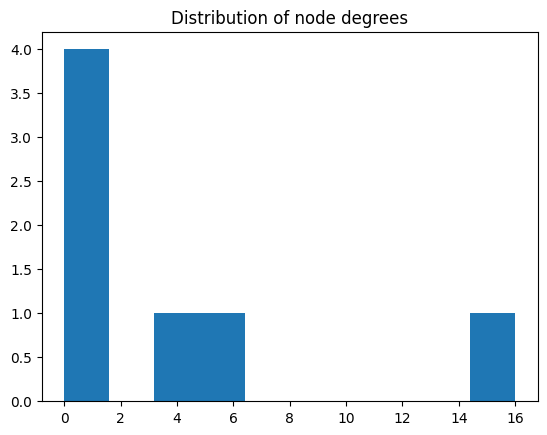

In [ ]:
# Get the number of connected components
print(f"Number of connected components: {nx.number_connected_components(g)}")

# Get the distribution of node degrees
plt.hist(nx.degree_histogram(g))
plt.title("Distribution of node degrees");

The histogram shows the node degree (number of connections) of each node in the graph along the x-axis, and the frequency (how many nodes have each degree) along the y-axis.

### 4.8 Plot Knowledge Graph

In [ ]:
g = index.get_networkx_graph()
net = Network(notebook=True, cdn_resources="in_line", directed=True)
net.from_nx(g)
print(f"Graph with {g.number_of_nodes()} nodes and {g.number_of_edges()} edges.")

# Generate the graph and save to HTML file
net.save_graph('kg_rebel_llamaindex_1.html')

# Display the graph
display(HTML(filename='kg_rebel_llamaindex_1.html'))

Graph with 26 nodes and 22 edges.


We can see that the graph is made up of 7 connected components with 26 nodes and 22 edges, although not all triples are present,  for example, `'chronic graft-versus-host disease', 'medical condition treated', 'thalidomide'` is missing.

### 4.9 Querying the Knowledge Graph

We will query the knowledge graph to extract some information. During queries, keywords are extracted from the query text, and used to find triplets (and their associated text chunks) that have the same subject in the triplet.

We can do this by building a [query engine](https://docs.llamaindex.ai/en/stable/module_guides/deploying/query_engine/usage_pattern/) from the index following the usage pattern `query_engine = index.as_query_engine()` and asking a question over our data `response = query_engine.query("Which drugs treat COVID-19?")`







In [ ]:
response = index.as_query_engine().query("What does sildenafil treat?")
print(response)

Sildenafil treats erectile dysfunction, pulmonary hypertension, and male erectile dysfunction.


By default the `include_embeddings` parameter is set to `False` when initialising the `KnowledgeGraphIndex` resulting in the warning about skipping embedding usage.

Also, two of the conditions listed in the answer as being treated by sildenafil are actually the same thing. It is likely that REBEL has hallucinated and extracted partial entities rather than an exact match as we did not use the adapted function from the previous notebook to resolve this issue.

In [ ]:
response = index.as_query_engine().query("What other drugs are mentioned?")
print(response)

None.


This response is incorrect. We will try again with slightly different wording.



In [ ]:
response = index.as_query_engine().query("Tell me about the drugs mentioned in the text?")
print(response)

There are no drugs mentioned in the text.


Again, an incorrect response. Using embeddings and performing a semantic search might give better output.

There is a mode in the `KnowledgeGraphIndex` retriever ([`include_text=True`](https://github.com/run-llama/llama_index/blob/6dc9b63f8b6b859c1fc72c00a0f9b7e5ffdc6a70/llama-index-core/llama_index/core/indices/knowledge_graph/retrievers.py#L81)) where the text source for matching triplets is used during a query instead of the triplets themselves. `True` is the default setting for this as it is usually preferable to triplets alone which typically lack a lot of context. However, there might be instances where we would want to change the parameter to `include_text=False` to restrict the LLM so that it only considers the triplets as context.

We will try asking specifically about a drug that we know is in the text.

In [ ]:
response = index.as_query_engine().query("What about bupropion?")
print(response)

Bupropion is a drug used for the treatment of smoking cessation.


This is correct as there is a triplet for `'bupropion', 'drug used for treatment', 'smoking cessation'`.

We will ask about thalidomide as the knowledge graph visualisation only had a triplet for `'multiple myeloma', 'medical condition treated', 'thalidomide'` when it should also have included `'chronic graft-versus-host disease', 'medical condition treated', 'thalidomide'`. Both are in the same chunk.

In [ ]:
response = index.as_query_engine().query("And thalidomide?")
print(response)

...is used for the treatment of multiple myeloma.


It fails to return chronic graft-versus-host disease as this was not extracted by REBEL for some reason. We will try again with different wording.

In [ ]:
response = index.as_query_engine().query("List everything that thalidomide treats?")
print(response)

multiple myeloma, chronic graft-versus-host disease


The correct answer this time.

One more instance of this sort of inconsistency occurred with the following query.

In [ ]:
response = index.as_query_engine().query("List all the diseases mentioned in the text?")
print(response)

There are no diseases mentioned in the text.


This is clearly incorrect but asking the same query again at a different time returned a different answer.

In [ ]:
response = index.as_query_engine().query("List all the diseases mentioned in the text?")
print(response)

The text mentions the following diseases: neurological diseases, cancer, rare diseases, and infectious diseases.


We will try one more query about bioinformatics which was in the largest connected component, and  the node  with the most edges.

In [ ]:
response = index.as_query_engine().query("Tell me about bioinformatics")

Bioinformatics is part of systems biology, genomics, and cheminformatics. It is also a subclass of computer methods and systematic computer methods. Additionally, bioinformatics is part of artificial intelligence.


This answer seems to have captured all the relationships for this node.

### 4.10 Query with embeddings

The `include_embeddings` parameter determines whether to include embeddings in the index. It defaults to `False` so previously our index was not constructed with embeddings. We will initialise another `KnowledgeGraphIndex` and set `include_embeddings=True`. Ensuring that semantic embeddings of the knowledge graph's nodes and edges are included in the index will facilitate semantically-driven queries.

In [ ]:
%%time
new_index = KnowledgeGraphIndex.from_documents(
    documents[0:5],
    kg_triplet_extract_fn=extract_triplets,
    include_embeddings=True,
)

CPU times: user 1min 20s, sys: 1.11 s, total: 1min 21s
Wall time: 1min 32s


We will build another query engine from the new index and add some parameters to the `.as_query_engine` method:

* We will keep `include_text=True` which is the default.

* We will add [`response_mode="tree_summarize"`](https://docs.llamaindex.ai/en/stable/module_guides/deploying/query_engine/response_modes/) which queries the LLM using the `summary_template` prompt as many times as needed so that all concatenated chunks have been queried, resulting in as many answers that are themselves recursively used as chunks in a `tree_summarize` LLM call and so on, until there's only one chunk left, and thus only one final answer.

* We will add [`retriever_mode="hybrid"`](https://github.com/run-llama/llama_index/blob/6dc9b63f8b6b859c1fc72c00a0f9b7e5ffdc6a70/llama-index-core/llama_index/core/indices/knowledge_graph/retrievers.py#L83). The `retriever_mode` specifies whether to use keywords, embeddings, or both to find relevant triplets and should be one of "keyword",      "embedding", or "hybrid".

* We will add [`similarity_top_k=5`](https://github.com/run-llama/llama_index/blob/6dc9b63f8b6b859c1fc72c00a0f9b7e5ffdc6a70/llama-index-core/llama_index/core/indices/knowledge_graph/retrievers.py#L86) so that the index will fetch the top 5 closest matching terms/definitions to the query. This parameter is the number of top embeddings to use (if embeddings are used).

In [ ]:
# query using top 5 triplets plus keywords (duplicate triplets are removed)
query_engine = new_index.as_query_engine(
    include_text=True,
    response_mode="tree_summarize",
    retriever_mode="hybrid",
    similarity_top_k=5,
)

In [ ]:
response = query_engine.query("What does sildenafil treat?")
print(response)

Sildenafil treats male erectile dysfunction, pulmonary hypertension, and erectile dysfunction.


Again the duplicate extracted by REBEL, we will try rephrasing the query to the LLM.

In [ ]:
response = query_engine.query("What does sildenafil treat? Do not return duplicates or synonyms.") # 10/11/24
print(response)

Sildenafil treats male erectile dysfunction and pulmonary hypertension.


This resolves the issue. We will try a few more queries.

In [ ]:
response = query_engine.query("Tell me about the drugs mentioned in the text?")
print(response)

The text mentions four drugs: aspirin, sildenafil, bupropion, and thalidomide.


In [ ]:
response = query_engine.query("Tell me about all of the drugs mentioned in the text?")
print(response)

Based on the provided information, the drugs mentioned are aspirin, sildenafil, bupropion, and thalidomide.


Even altering the query by a single word can result in a slightly different and more natural sounding response.

In [ ]:
response = query_engine.query("What about bupropion?")
print(response)

Bupropion is a drug used for the treatment of smoking cessation.


In [ ]:
response = query_engine.query("And thalidomide?")
print(response)

It is used for the treatment of multiple myeloma.


Again, only one condition is mentioned so we will alter the prompt.

In [ ]:
response = query_engine.query("List everything that thalidomide treats?")
print(response)

Based on the provided information, thalidomide treats multiple myeloma and chronic graft-versus-host disease.


In [ ]:
response = query_engine.query("List all the diseases mentioned in the text?")
print(response)

Here is the list of diseases mentioned in the text:

1. Neurological diseases
2. Cancer
3. Infectious diseases
4. Rare diseases
5. Male erectile dysfunction
6. Pulmonary hypertension
7. Multiple myeloma
8. Chronic graft-versus-host disease


This is a better response than querying without embeddings which only returned 4 list items. Adding the term 'conditions' to the query below also results in an extra list item (Smoking cessation).

In [ ]:
response = query_engine.query("List all the conditions and diseases mentioned in the text?")
print(response)

Here is the list of conditions and diseases mentioned in the text:

1. Male erectile dysfunction
2. Pulmonary hypertension
3. Smoking cessation
4. Multiple myeloma
5. Chronic graft-versus-host disease
6. Neurological diseases
7. Cancer
8. Infectious diseases
9. Rare diseases


In [ ]:
response = query_engine.query("List all the conditions and treatments mentioned in the text?")
print(response)

Here is the list of conditions and treatments mentioned in the text:

Conditions:

* Male erectile dysfunction
* Pulmonary hypertension
* Multiple myeloma
* Chronic graft-versus-host disease
* Smoking cessation

Treatments:

* Sildenafil
* Bupropion
* Thalidomide
* Aspirin


Adding the word 'corresponding' to the query below results in the condition being mapped to the treatment which is more useful than two separate lists in the previous response.

In [ ]:
response = query_engine.query("List all the conditions and corresponding treatments mentioned in the text?")
print(response)

Based on the provided information, the conditions and corresponding treatments mentioned are:

* Male erectile dysfunction: sildenafil
* Pulmonary hypertension: sildenafil
* Multiple myeloma: thalidomide
* Smoking cessation: bupropion
* Chronic graft-versus-host disease: thalidomide


In [ ]:
response = query_engine.query("Describe all the drugs, treatments, diseases and conditions in the text.")
print(response)

Here is the description of drugs, treatments, diseases, and conditions mentioned in the text:

Drugs: sildenafil, bupropion, thalidomide, aspirin

Treatments: drug repurposing, smoking cessation

Diseases/Conditions: male erectile dysfunction, pulmonary hypertension, multiple myeloma, chronic graft-versus-host disease


Here again a very subtle change altered the structure of the response.

In [ ]:
response = query_engine.query("Describe all of the different drugs and treatments mentioned in the text.")
print(response)

Based on the provided information, the following drugs and treatments are mentioned:

1. Aspirin - a drug used for repurposing
2. Sildenafil - repositioned for male erectile dysfunction and pulmonary hypertension
3. Bupropion - used for smoking cessation
4. Thalidomide - used for treating multiple myeloma and chronic graft-versus-host disease


## 5. REBEL and LlamaIndex Knowledge Graph for all documents

### 5.1 Construct Knowledge Graph Index

We will build a `KnowledgeGraphIndex` for all sentences containing entities from the 10 articles and extract triplets with REBEL using the custom `extract_triplets` function.

In [ ]:
%%time

index = KnowledgeGraphIndex.from_documents(
    documents,
    kg_triplet_extract_fn=extract_triplets,
    include_embeddings=True,
)

CPU times: user 3h 43min 28s, sys: 24.7 s, total: 3h 43min 53s
Wall time: 3h 47min 40s


This took a long time to run as we are using cpu as device.

### 5.2 Query the Knowledge Graph

We will try some of the same queries as for the first five documents on the whole dataset.



In [ ]:
response = index.as_query_engine().query("List all the conditions and corresponding treatments mentioned in the text?")
print(response)

Based on the provided context, the conditions and corresponding treatments mentioned are:

* COVID-19: 
  - bosutinib (potential treatment)
  - saquinavir (repurposed drug with best efficacy in in silico environment)
  - ritonavir (repurposed drug with best efficacy in in silico environment)
  - lopinavir (repurposed drug with best efficacy in in silico environment)
  - anticancer drugs (reviewed for management)
  - repurposed approved drugs (with new mechanism of action)
  - natural products (e.g., herbal medicine)
  - existing COVID-19 treatment medication (similar drugs identified)
  - various repurposed drugs (reported for use against COVID-19, some already available on the market)


More conditions than just COVID-19 were mentioned in the text but do not seem to be captured in the response.

In [ ]:
response = index.as_query_engine().query("List all the conditions and diseases and corresponding treatments mentioned in the text?")
print(response)

Here is the list of conditions and diseases with corresponding treatments mentioned in the text:

1. COVID-19 - treatment (no specific treatment mentioned)
2. HIV - antiviral drugs (previously known treatment)
3. Hepatitis - antiviral drugs (previously known treatment)
4. Influenza - antiviral drugs (previously known treatment)
5. Ebola - antiviral drugs (previously known treatment)
6. Cancer - drug repositioning, Weighted gene co-expression network analysis (WGCNA) for identifying novel biomarkers and therapeutic targets
7. Autoimmune diseases - no specific treatment mentioned
8. Malignant diseases - no specific treatment mentioned
9. Cardiovascular diseases - no specific treatment mentioned
10. Metabolic diseases - no specific treatment mentioned
11. Neurological diseases - drug repositioning
12. Pulmonary diseases - no specific treatment mentioned
13. Rare diseases - drug repositioning
14. Infectious diseases - drug repositioning
15. COVID-19 - Molnupiravir (Lagevrio) as an oral the

This response not perfect either as COVID-19 is mentioned in point 1. with no specific treatment mentioned, but is listed again in 14. and 15. with specific drugs mentioned.

In [ ]:
response = index.as_query_engine().query("Tell me about the drugs mentioned in the text?")
print(response)

Based on the provided context, the following drugs are mentioned: chloroquine, hydroxychloroquine, ramipril, delapril, and lisinopril. Additionally, it is mentioned that antiviral, antimalarial, and anti-HIV drugs have been shown to be effective in treating COVID-19.


In [ ]:
response = index.as_query_engine().query("List all the drugs mentioned in the text?")
print(response)

Based on the provided context, the drugs mentioned in the text are:

1. Chloroquine
2. Hydroxychloroquine
3. Ramipril
4. Delapril
5. Lisinopril
6. Molnupiravir
7. Lagevrio


The response in list format above is slightly different in that the last two drugs mentioned were not in the previous response which more broadly mentioned antiviral, antimalarial, and anti-HIV drugs.

In [ ]:
response = index.as_query_engine().query("List all the diseases mentioned in the text?")
print(response)

Here is the list of diseases mentioned in the text:

1. Covid-19
2. Autoimmune diseases
3. Malignant diseases
4. Cancer
5. Cardiovascular diseases
6. Metabolic diseases
7. Neurological diseases
8. Pulmonary diseases


The list begins with COVID-19 which makes sense as the articles are generally about drug repurposing for COVID-19, and the others sound like broad categories of diseases. This appears to be a more general summary and differs somewhat from the same query for the first five documents which gave the following response including more specific diseases:

1. Neurological diseases
2. Cancer
3. Infectious diseases
4. Rare diseases
5. Male erectile dysfunction
6. Pulmonary hypertension
7. Multiple myeloma
8. Chronic graft-versus-host disease


### 5.3 Plot Knowledge Graph

In [ ]:
g = index.get_networkx_graph()
net = Network(notebook=True, cdn_resources="in_line", directed=True)
net.from_nx(g)
print(f"Graph with {g.number_of_nodes()} nodes and {g.number_of_edges()} edges.")

# Generate the graph and save to HTML file
net.save_graph('kg_rebel_llamaindex_all.html')

# Display the graph
display(HTML(filename='kg_rebel_llamaindex_all.html'))

Graph with 66 nodes and 63 edges.


Understandably, there are more nodes and edges (66 nodes and 63 edges) and larger connected components than for the smaller dataset.

## 6. LlamaIndex only Knowledge Graph for all documents

### 6.1 Construct Knowledge Graph Index

We will build a `KnowledgeGraphIndex` for all sentences containing entities from the 10 articles without using REBEL and the custom `extract_triplets` function. We will just use the default LlamaIndex triplet extraction function this time with Llama3-70b as the LLM to extract triplets.

In [ ]:
%%time

index = KnowledgeGraphIndex.from_documents(
    documents,
    include_embeddings=True,
)


CPU times: user 2min 39s, sys: 3.23 s, total: 2min 42s
Wall time: 58min 4s


### 6.2 Query the Knowledge Graph

We will try some of the same queries as before and compare responses.

In [ ]:
response = index.as_query_engine().query("List all the conditions and corresponding treatments mentioned in the text?")
print(response)

Based on the provided context, the conditions and corresponding treatments mentioned are:

* Covid-19: drug repurposing, lopinavir/ritonavir, hydroxychloroquine
* Ebola: drug repositioning
* HIV: drug repositioning
* Zika virus: drug repositioning
* Novel coronaviruses: drug repositioning
* Rare diseases: precision medicine and drug repositioning
* Genetically related diseases: precision medicine and drug repositioning
* Cytokine storm: no specific treatment mentioned
* Comorbidities: inspected side effects of drug candidate based on genetic information
* Viral infections: predicting influence of existing drugs on preexisting conditions
* Infection in human cells: inhibiting RNA-dependent RNA polymerase RdRp


In [ ]:
response = index.as_query_engine().query("List all the conditions and diseases and corresponding treatments mentioned in the text?")
print(response)

Here is the list of conditions, diseases, and corresponding treatments mentioned in the text:

1. Ebola - Antiviral drugs (through drug repositioning)
2. HIV - Antiviral drugs (through drug repositioning)
3. Zika virus - Antiviral drugs (through drug repositioning)
4. Novel coronaviruses - Antiviral drugs (through drug repositioning)
5. Covid-19 - 
   a. Drug repurposing (through network-based approaches, Few-Shot learning, and multi-targeted drug repurposing strategy)
   b. Antiviral drugs (through drug repositioning)
   c. OAS3 (oligoadenylate synthase family of proteins that degrades viral RNA and activates antiviral responses)
6. Autoimmune - (no specific treatment mentioned)
7. Malignant - (no specific treatment mentioned)
8. Cancer - (no specific treatment mentioned)
9. Cardiovascular - (no specific treatment mentioned)
10. Metabolic - (no specific treatment mentioned)
11. Neurological - (no specific treatment mentioned)
12. Pulmonary - (no specific treatment mentioned)

Note tha

In [ ]:
response = index.as_query_engine().query("Tell me about the drugs mentioned in the text?")
print(response)

The text mentions Antiviral drugs, Metformin, Statins, and Antibiotics as examples of drugs that were often repositioned during recent years for various viral diseases such as hepatitis C, Ebola virus, and influenza.


In [ ]:
response = index.as_query_engine().query("List all the drugs mentioned in the text?")
print(response)

Based on the provided context, the drugs mentioned are: Metformin, Statins, Antibiotics, and Bexarotene.


This response only mentions four drugs.

In [ ]:
response = index.as_query_engine().query("List all the diseases mentioned in the text?")
print(response)

Here is the list of diseases mentioned in the text:

1. Ebola
2. HIV
3. Zika virus
4. COVID-19
5. SIRS
6. Sepsis
7. Burns
8. Severe trauma
9. Cytokine storms


This does not appear to be a comprehensive list either and further tuning of parameters would be required to see if output could be improved.

### 6.3 Plot Knowledge Graph

In [ ]:
g = index.get_networkx_graph()
net = Network(notebook=True, cdn_resources="in_line", directed=True)
net.from_nx(g)
print(f"Number of nodes: {g.number_of_nodes()}")
print(f"Number of edges: {g.number_of_edges()}")
net.show('kg_example_all.html')

IPython.display.HTML(filename='kg_example_all.html')

Number of nodes: 90
Number of edges: 96
kg_example_all.html


There are more nodes and edges (90 nodes and 96 edges) and therefore higher recall than for REBEL triplet extraction (66 nodes and 63 edges). However, REBEL is fine-tuned for triplet extraction and may produce more precise output.

### References


* REBEL + Knowledge Graph Index https://colab.research.google.com/drive/1G6pcR0pXvSkdMQlAK_P-IrYgo-_staxd?usp=sharing

* https://docs.llamaindex.ai/en/stable/examples/index_structs/knowledge_graph/KnowledgeGraphDemo/

* https://www.llamaindex.ai/blog/evaluating-the-ideal-chunk-size-for-a-rag-system-using-llamaindex-6207e5d3fec5

* https://docs.llamaindex.ai/en/stable/optimizing/basic_strategies/basic_strategies/#chunk-sizes

* https://docs.llamaindex.ai/en/stable/examples/llm/groq/

* https://www.llamaindex.ai/blog/customizing-property-graph-index-in-llamaindex

* https://github.com/tomasonjo/blogs/blob/master/llm/Llamaindex-rebel-neo4j.ipynb

* https://medium.com/@filip.igor.wojcik/structured-knowledge-extraction-from-dbpedia-queries-to-llama-index-knowledge-graphs-47899c38e767

* https://medium.com/@sauravjoshi23/building-knowledge-graphs-rebel-llamaindex-and-rebel-llamaindex-8769cf800115

* https://medium.com/@haiyangli_38602/make-meaningful-knowledge-graph-from-opensource-rebel-model-6f9729a55527

* https://siwei.io/graph-enabled-llama-index/knowledge_graph_query_engine.html

* https://medium.com/@nikunjbediaw/index-records-from-a-dataframe-in-llamaindex-for-llm-apps-1f1781a4889b

* https://medium.com/@leighphil4/knowledge-graphs-in-rags-with-llama-index-85830c0cbcc5

* https://huggingface.co/blog/how-to-generate



